with 300K combined model and 1M combined model

tensorflow hybrid model....

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [4]:
result = pd.read_csv('/Users/qingpeng/Dropbox/Genelearn/VicaData/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

### Formular to calcuate hybrid probability score from score from old model and euk/non-euk model

In [5]:
result["hybrid_probability"] = (result["score_euk_non_euk"] * result["probability"])**0.5

In [6]:
result["hybrid_prediction"] = (result.hybrid_probability >0.5)

In [7]:
result.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,score_non_euk_virus,pred_non_euk_virus,score_virus_non_virus,pred_virus_non_virus,hybrid_probability,hybrid_prediction
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,0.996004,1.0,0.001954,0.0,0.000097,False
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.995278,1.0,0.000529,0.0,0.000032,False
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.996629,1.0,0.000761,0.0,0.000019,False
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.991967,1.0,0.000477,0.0,0.000021,False
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.990354,1.0,0.000617,0.0,0.000018,False


In [8]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('./Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


In [9]:
ranks = ncbi.get_lineage(186616)

In [10]:
ranks

[1, 10239, 186616]

In [11]:
megan_annot.head()

,name,tax_id,rank,tax_name,top_label
0,NODE_646_length_5889_cov_28.079_g448_i0,1,no rank,root,N/A
1,NODE_667_length_5857_cov_28.2491_g448_i1,1,no rank,root,N/A
2,NODE_671_length_5843_cov_18.2623_g465_i0,1,no rank,root,N/A
3,NODE_806_length_5513_cov_46.199_g556_i0,1,no rank,root,N/A
4,NODE_807_length_5513_cov_37.6629_g556_i1,1,no rank,root,N/A


In [12]:
len(megan_annot)

208302

In [13]:
new_table = pd.merge(result,megan_annot, on=['name'])

In [14]:
prediction_virus_nonvirus = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.virus_nonvirus')

In [16]:
prediction_virus_nonvirus.head()

,ID,Class,Class_id,Prob_class_0,Prob_class_1,Prob_class_2,Prob_class_3,Prob_class_4,Prob_class_5
0,NODE_10000_length_2000_cov_95.909_g6946_i0,1,1,1.623740e-04,0.704973,6.937620e-04,2.507750e-04,1.744850e-04,0.293745
1,NODE_10000_length_2048_cov_10.8329_g7692_i0,1,1,3.197970e-09,0.998480,1.617200e-07,1.618830e-07,8.445450e-10,0.001520
2,NODE_10000_length_2108_cov_40.585_g7688_i0,1,1,1.102410e-08,0.999432,1.488250e-07,1.922180e-07,1.127840e-09,0.000568
3,NODE_10000_length_2114_cov_17.7008_g7479_i0,1,1,5.496490e-06,0.981986,4.395280e-05,3.292910e-05,1.873910e-06,0.017930
4,NODE_10000_length_2132_cov_22.4521_g7241_i0,1,1,8.687760e-10,0.977273,3.073050e-08,4.356720e-09,1.664910e-09,0.022727


In [18]:
prediction_virus_nonvirus_subset = prediction_virus_nonvirus[['ID','Prob_class_1']]

In [15]:
prediction_euk_noneuk = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.euk_noneuk')

In [28]:
prediction_euk_noneuk_subset = prediction_euk_noneuk[['ID','Prob_class_4']]

In [67]:
prediction_300k = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.300k')

In [69]:
prediction_300k_subset = prediction_300k[['ID','Prob_class_1']]

In [ ]:
prediction_300k_subset = prediction_300k[['ID','Prob_class_1']]

In [70]:
prediction_300k_subset.rename(index=str,columns={"ID": "name"},inplace=True)

In [71]:
prediction_300k_subset.rename(index=str,columns={"Prob_class_1": "300k_prediction"},inplace=True)

In [30]:
prediction_euk_noneuk_subset.rename(index=str,columns={"ID": "name"},inplace=True)

In [23]:
prediction_virus_nonvirus_subset.rename(index=str,columns={"ID": "name"},inplace=True)

In [31]:
new_table_combined = pd.merge(new_table,prediction_euk_noneuk_subset, how='left',on=['name'])

In [34]:
new_table_combined2 = pd.merge(new_table_combined,prediction_virus_nonvirus_subset, how='left',on=['name'])

In [73]:
new_table_combined300 = pd.merge(new_table_combined2,prediction_300k_subset, how='left',on=['name'])

In [36]:
new_table_combined2["tensorflow_hybrid_probability"] = (new_table_combined2["Prob_class_1"] * new_table_combined2["Prob_class_4"])**0.5

In [74]:
new_table_combined300["tensorflow_hybrid300_probability"] = (new_table_combined300["300k_prediction"] * new_table_combined300["Prob_class_4"])**0.5

In [81]:
new_table_combined300["tensorflow_hybrid300_probability_plus"] = (new_table_combined300["300k_prediction"] * new_table_combined300["Prob_class_4"])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

### 208302 contigs with length >=2k, in TARA


In [38]:
new_table_combined2["non_euk_label"] = (new_table_combined2.top_label!='Eukaryota')

In [39]:
new_table_combined2["micromonas_label"] = (new_table_combined2.tax_name=='Micromonas') |(new_table_combined2.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table_combined2.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [40]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [41]:
new_table_combined2['annotation_label'] = new_table_combined2['top_label'].map(convert_top_label)

### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [85]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table_combined300[new_table_combined300.label==0.0][new_table_combined300['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
#df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table_combined300[new_table_combined300.label==0.0][new_table_combined300['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
#df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table_combined300[new_table_combined300.label==1.0]
#df_virus.to_csv('df_virus.csv')



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [43]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [44]:
new_table_combined2['category'] = new_table_combined2.apply(get_category, axis=1)

In [45]:
new_table_combined2.groupby('category').describe()


Prob_class_1                                                        \
                count      mean       std           min       25%       50%   
category                                                                      
nonvirus     190956.0  0.568637  0.402417  0.000000e+00  0.106391  0.700138   
unknown       10202.0  0.704651  0.373262  1.353230e-08  0.380825  0.936031   
virus          7041.0  0.980793  0.081236  2.543660e-06  0.991705  0.997998   

                        Prob_class_4           ...   \
               75%  max        count      mean ...    
category                                       ...    
nonvirus  0.973902  1.0     190956.0  0.831277 ...    
unknown   0.996212  1.0      10202.0  0.851397 ...    
virus     0.999520  1.0       7041.0  0.976816 ...    

         tensorflow_hybrid_probability           vfam                      \
                                   75%  max     count      mean       std   
category                                                                    
nonvirus                      0.960870  1.0  191023.0  0.000000  0.000000   
unknown                       0.995344  1.0   10238.0  0.000000  0.000000   
virus                         0.999563  1.0    7041.0  0.014771  0.120642   

                                   
          min  25%  50%  75%  max  
category                           
nonvirus  0.0  0.0  0.0  0.0  0.0  
unknown   0.0  0.0  0.0  0.0  0.0  
virus     0.0  0.0  0.0  0.0  1.0  

[3 rows x 144 columns]

#### subsample "non-euk" to have same number of "euk" contigs, for evaluating euk/non-euk model

In [87]:
# "non-euk" data frame... non-virus and with annotation by MEGAN
df_euk = new_table_combined300[new_table_combined300.non_euk_label==False][new_table_combined300['annotation_label']== 'with annotation']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


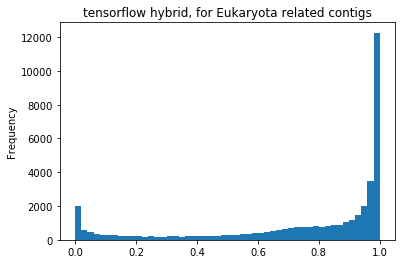

In [59]:
df_euk.tensorflow_hybrid_probability.plot.hist(bins=50, title='tensorflow hybrid, for Eukaryota related contigs')

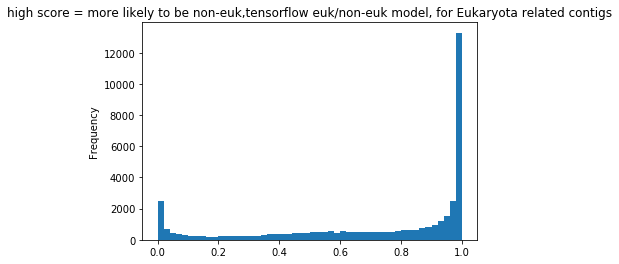

In [118]:
df_euk.Prob_class_4.plot.hist(bins=50, title='high score = more likely to be non-euk,tensorflow euk/non-euk model, for Eukaryota related contigs')

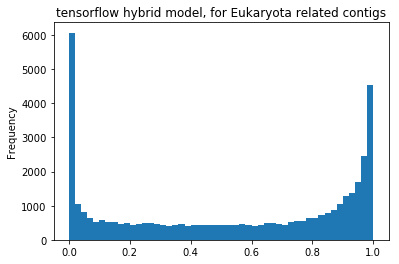

In [116]:
df_euk.tensorflow_hybrid300_probability_plus.plot.hist(bins=50, title='tensorflow hybrid model, for Eukaryota related contigs')

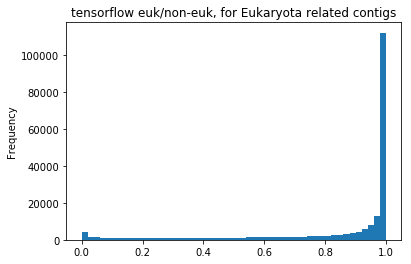

In [65]:
new_table_combined2.Prob_class_4.plot.hist(bins=50, title='tensorflow euk/non-euk, for Eukaryota related contigs')

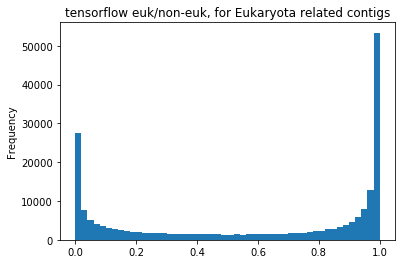

In [66]:
new_table_combined2.Prob_class_1.plot.hist(bins=50, title='tensorflow euk/non-euk, for Eukaryota related contigs')

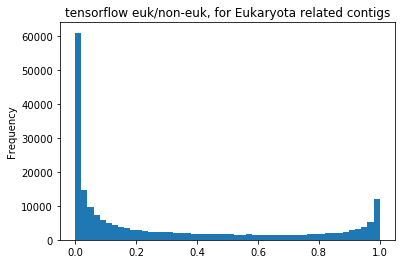

In [83]:
new_table_combined300.tensorflow_hybrid300_probability_plus.plot.hist(bins=50, title='tensorflow euk/non-euk, for Eukaryota related contigs')

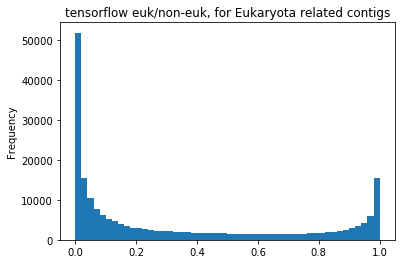

In [80]:
new_table_combined300['300k_prediction'].plot.hist(bins=50, title='tensorflow euk/non-euk, for Eukaryota related contigs')

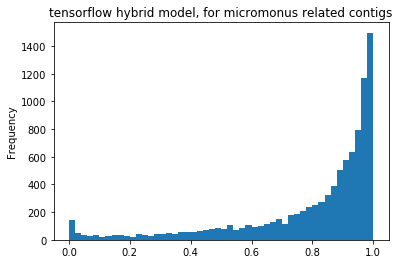

In [114]:
df_micromonus.tensorflow_hybrid300_probability_plus.plot.hist(bins=50, title='tensorflow hybrid model, for micromonus related contigs')

In [ ]:
df_micromonus.Prob_class_4.plot.hist(bins=50, title='tensorflow euk/non-euk, for Eukaryota related contigs')

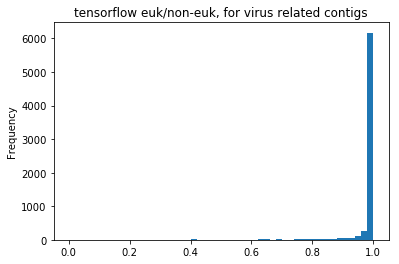

In [63]:
df_virus.Prob_class_4.plot.hist(bins=50, title='tensorflow euk/non-euk, for virus related contigs')

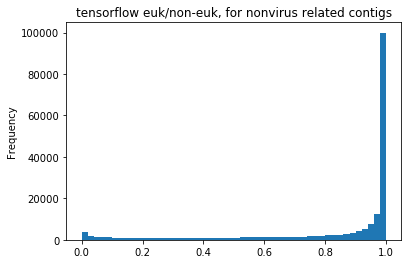

In [64]:
df_nonvirus.Prob_class_4.plot.hist(bins=50, title='tensorflow euk/non-euk, for nonvirus related contigs')

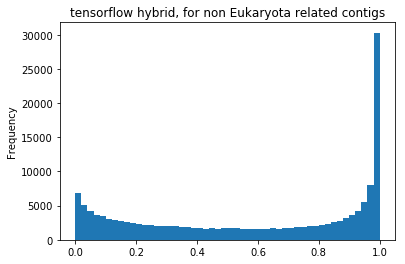

In [60]:
df_noneuk.tensorflow_hybrid_probability.plot.hist(bins=50, title='tensorflow hybrid, for non Eukaryota related contigs')

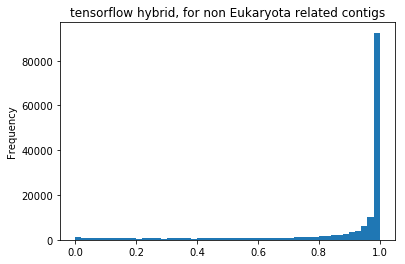

In [62]:
df_noneuk.Prob_class_4.plot.hist(bins=50, title='tensorflow hybrid, for non Eukaryota related contigs')

In [47]:
len(df_euk)

40920

In [48]:
df_euk.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,rank,tax_name,top_label,Prob_class_4,Prob_class_1,tensorflow_hybrid_probability,non_euk_label,micromonas_label,annotation_label,category
268,NODE_269_length_13662_cov_37.4019_g165_i0,13662,1.000000,1.0,0.0,0.0,0.0,0.0,0.618436,1.0,...,species,Bodo saltans,Eukaryota,0.952397,0.999624,0.975725,False,False,with annotation,nonvirus
326,NODE_327_length_11643_cov_43.6716_g200_i0,11643,0.000126,0.0,0.0,0.0,0.0,0.0,0.011231,0.0,...,no rank,Opisthokonta,Eukaryota,0.999874,0.019418,0.139338,False,False,with annotation,nonvirus
348,NODE_349_length_11091_cov_73.7458_g215_i0,11091,0.000057,0.0,0.0,0.0,0.0,0.0,0.045895,0.0,...,no rank,Beauveria bassiana D1-5,Eukaryota,0.993529,0.033658,0.182868,False,False,with annotation,nonvirus
517,NODE_518_length_8292_cov_38.7037_g335_i0,8292,0.002875,0.0,0.0,0.0,0.0,0.0,0.000803,0.0,...,no rank,Beauveria bassiana D1-5,Eukaryota,0.999869,0.414983,0.644150,False,False,with annotation,nonvirus
522,NODE_523_length_8242_cov_224.933_g340_i0,8242,0.000006,0.0,0.0,0.0,0.0,0.0,0.022461,0.0,...,no rank,Beauveria bassiana D1-5,Eukaryota,0.999984,0.001277,0.035731,False,False,with annotation,nonvirus


In [49]:
df_noneuk = new_table_combined2[new_table_combined2.non_euk_label==True][new_table_combined2['annotation_label']== 'with annotation']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [50]:
len(df_noneuk)

156823

In [51]:
df_noneuk_subsample = df_noneuk.sample(n=40920, replace=False)

In [52]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,tax_id,rank,tax_name,top_label,Prob_class_4,Prob_class_1,tensorflow_hybrid_probability,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,286,genus,Pseudomonas,Bacteria,0.817528,0.496003,0.636786,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,186616,no rank,environmental samples,Virus,0.999928,0.991453,0.995681,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,196896,no rank,unclassified Myoviridae,Virus,0.998542,0.968570,0.983442,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,196896,no rank,unclassified Myoviridae,Virus,0.999807,0.989361,0.994570,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,439488,no rank,ssRNA viruses,Virus,0.818282,0.986655,0.898533,True,False,with annotation


In [91]:
df_micromonus = new_table_combined300[new_table_combined300.micromonas_label==True]

In [54]:
len(df_micromonus)

9586

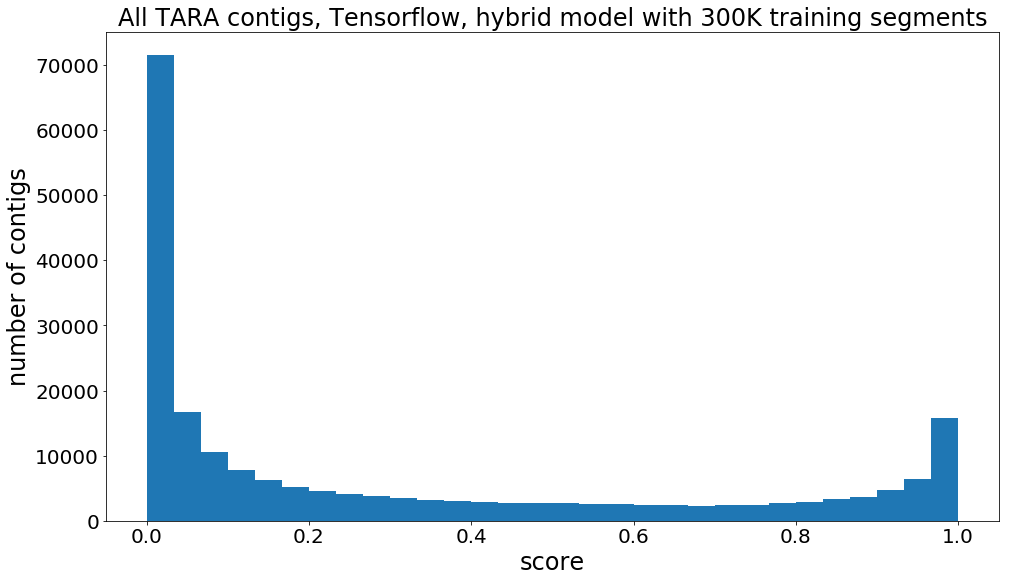

In [94]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [new_table_combined300[new_table_combined300.tensorflow_hybrid300_probability_plus>0].tensorflow_hybrid300_probability_plus]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'
                                                  ],
         )
ax0.set_title('All TARA contigs, Tensorflow, hybrid model with 300K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)



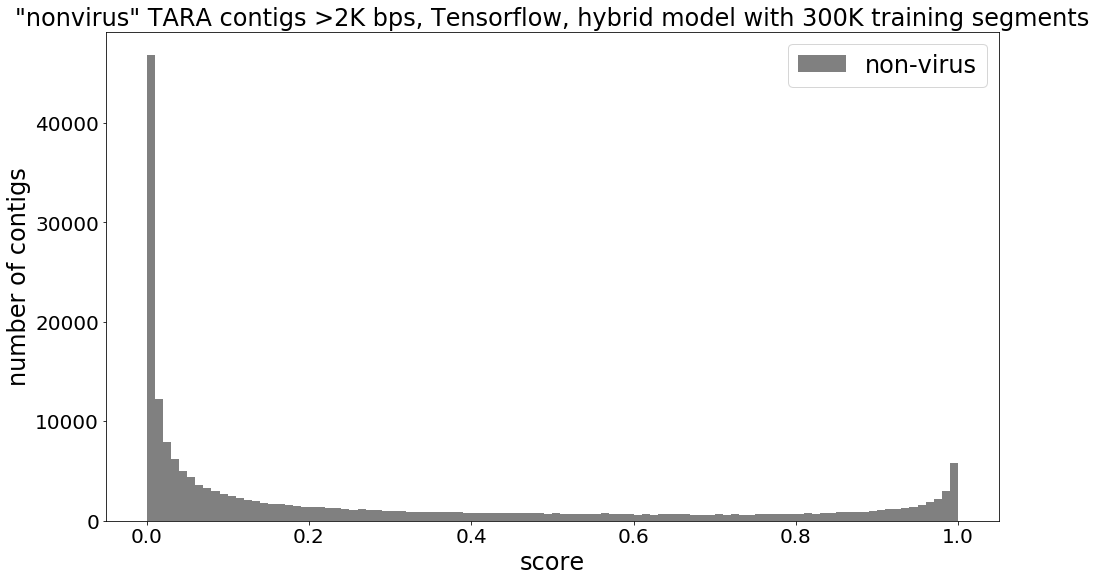

In [95]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 100
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus[df_nonvirus.tensorflow_hybrid300_probability_plus>0].tensorflow_hybrid300_probability_plus]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'non-virus'],
         color=['grey'])
ax0.set_title('"nonvirus" TARA contigs >2K bps, Tensorflow, hybrid model with 300K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

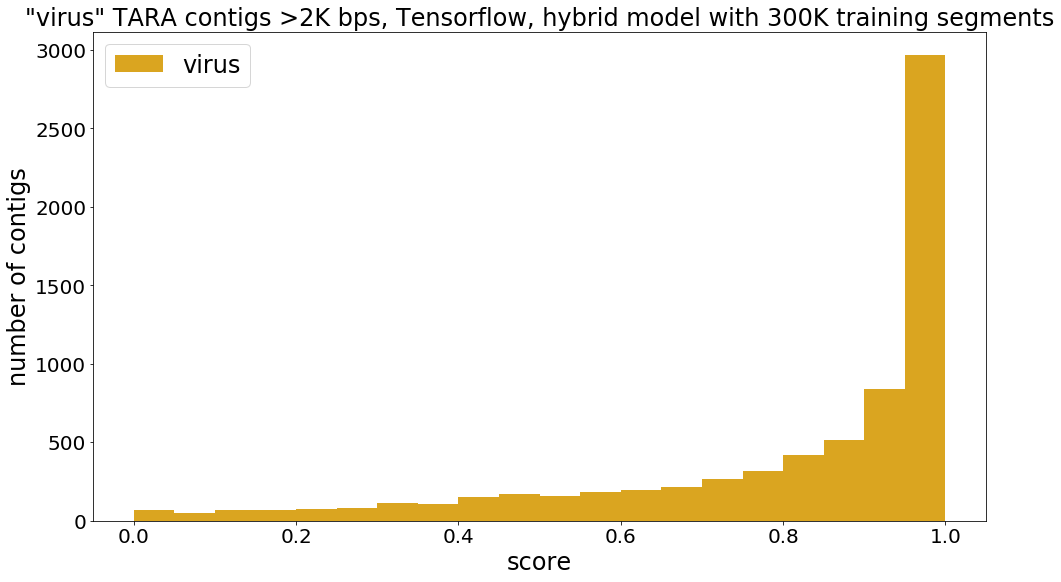

In [96]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 20
#colors = ['red', 'blue', 'grey']
x_multi = [df_virus[df_virus.tensorflow_hybrid300_probability_plus>0].tensorflow_hybrid300_probability_plus]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'virus'],
         color=['goldenrod'])
ax0.set_title('"virus" TARA contigs >2K bps, Tensorflow, hybrid model with 300K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

### Check the Precision-recall curve of old model and hybrid model

#### Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

#### Balanced data, same number of "virus" and "non-virus" contigs

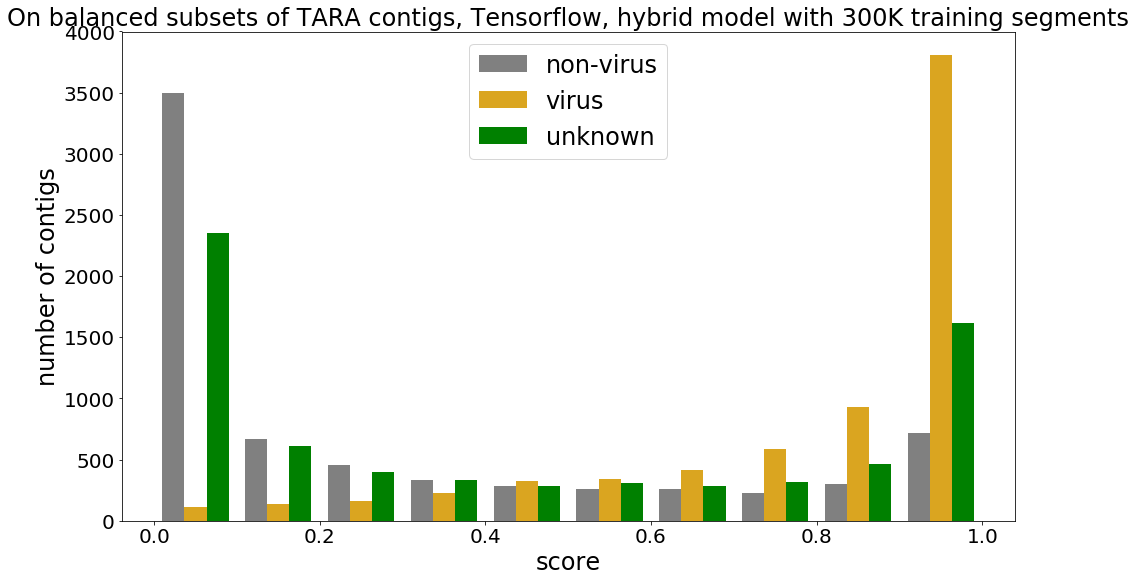

In [98]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.tensorflow_hybrid300_probability_plus,df_virus.tensorflow_hybrid300_probability_plus, df_unknown_subsample.tensorflow_hybrid300_probability_plus ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, Tensorflow, hybrid model with 300K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

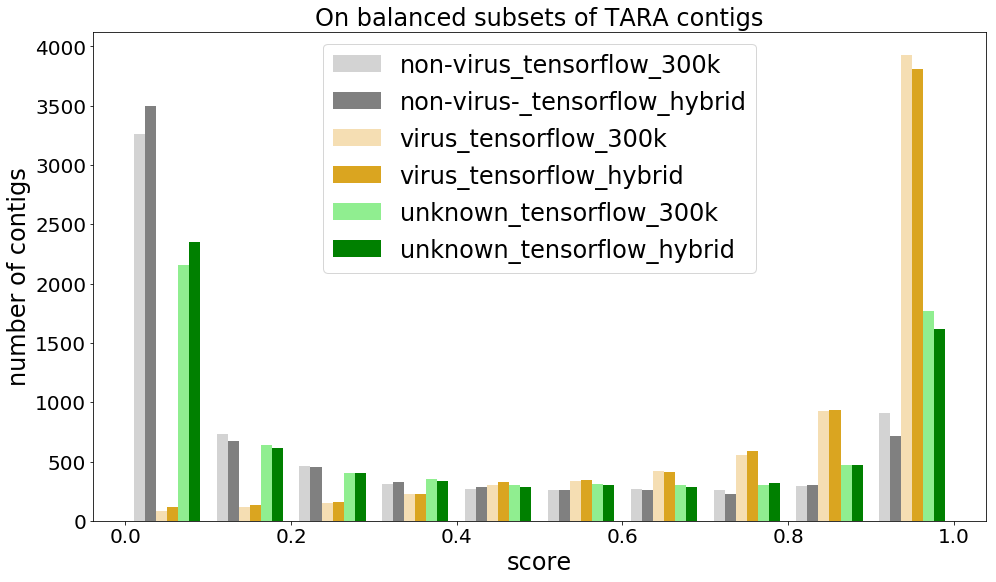

In [102]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample['300k_prediction'],df_nonvirus_subsample.tensorflow_hybrid300_probability_plus,df_virus['300k_prediction'],
           df_virus.tensorflow_hybrid300_probability_plus,df_unknown_subsample['300k_prediction'],df_unknown_subsample.tensorflow_hybrid300_probability_plus ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus_tensorflow_300k','non-virus-_tensorflow_hybrid',
                                                  'virus_tensorflow_300k','virus_tensorflow_hybrid',
                                                  'unknown_tensorflow_300k','unknown_tensorflow_hybrid'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

In [103]:
balaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus_subsample])
balaced_matrix_virus_nonvirus_hybrid = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_prediction)
auprc_balaced_virus_nonvirus_hybrid = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)
precision_balaced_virus_nonvirus_hybrid, recall_balaced_virus_nonvirus_hybrid, thresholds_balaced_virus_nonvirus_hybrid = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)

balaced_matrix_virus_nonvirus_old = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.prediction)
auprc_balaced_virus_nonvirus_old = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)
precision_balaced_virus_nonvirus_old, recall_balaced_virus_nonvirus_old, thresholds_balaced_virus_nonvirus_old = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)


        

In [105]:
#balaced_matrix_virus_nonvirus_dl = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.Prob_class_1)
auprc_balaced_virus_nonvirus_dl = average_precision_score(balaced_virus_nonvirus[balaced_virus_nonvirus['300k_prediction']>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus['300k_prediction']>0]['300k_prediction'])
precision_balaced_virus_nonvirus_dl, recall_balaced_virus_nonvirus_dl, thresholds_balaced_virus_nonvirus_dl = precision_recall_curve(
    balaced_virus_nonvirus[balaced_virus_nonvirus['300k_prediction']>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus['300k_prediction']>0]['300k_prediction'])



In [111]:
auprc_balaced_virus_nonvirus_dl_hybrid = average_precision_score(balaced_virus_nonvirus[balaced_virus_nonvirus.tensorflow_hybrid300_probability_plus>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.tensorflow_hybrid300_probability_plus>0].tensorflow_hybrid300_probability_plus)
precision_balaced_virus_nonvirus_dl_hybrid, recall_balaced_virus_nonvirus_dl_hybrid, thresholds_balaced_virus_nonvirus_dl_hybrid = precision_recall_curve(
    balaced_virus_nonvirus[balaced_virus_nonvirus.tensorflow_hybrid300_probability_plus>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.tensorflow_hybrid300_probability_plus>0].tensorflow_hybrid300_probability_plus)



In [113]:
auprc_balaced_virus_nonvirus_dl_hybrid

0.83070550664228804

ValueError: x and y must have same first dimension, but have shapes (13860,) and (13472,)

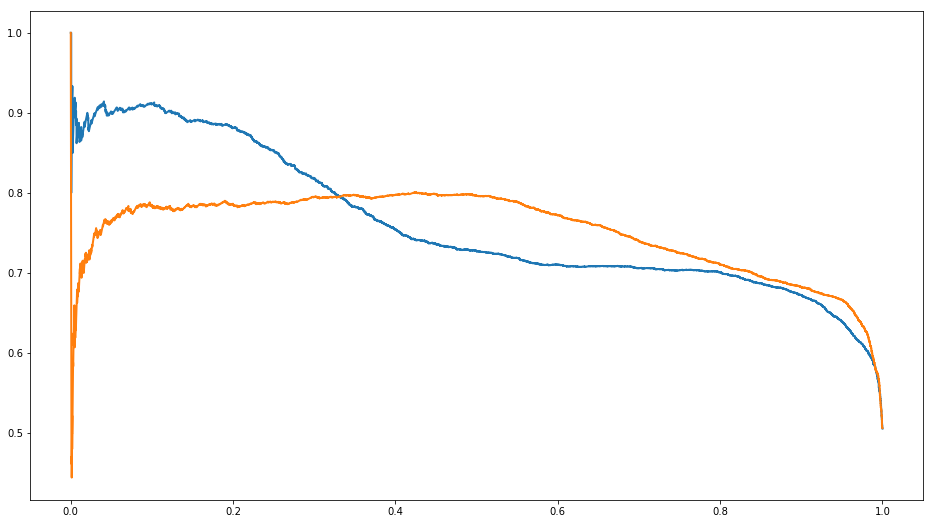

In [112]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='model v2.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='model v1.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))
        plt.plot(recall_balaced_virus_nonvirus_dl, precision_balaced_virus_nonvirus_dl, lw=lw, 
                 label='model tensorflow v2, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl))
        plt.plot(recall_balaced_virus_nonvirus_dl_hybrid, precision_balaced_virus_nonvirus_dl_hybrid, lw=lw, 
                 label='model tensorflow hybrid, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl_hybrid))
       
        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tick_params(labelsize=20)
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)



#### using all TARA contigs - imbalanced

In [60]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [61]:

imbalaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus])
imbalaced_matrix_virus_nonvirus_hybrid = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_prediction)
auprc_imbalaced_virus_nonvirus_hybrid = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)
precision_imbalaced_virus_nonvirus_hybrid, recall_imbalaced_virus_nonvirus_hybrid, thresholds_imbalaced_virus_nonvirus_hybrid = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)

imbalaced_matrix_virus_nonvirus_old = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.prediction)
auprc_imbalaced_virus_nonvirus_old = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)
precision_imbalaced_virus_nonvirus_old, recall_imbalaced_virus_nonvirus_old, thresholds_imbalaced_virus_nonvirus_old = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)


        
    

In [62]:
imbalaced_virus_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [63]:
imbalaced_matrix_virus_nonvirus_hybrid

array([[146072,  44951],
       [  2865,   4176]])

In [64]:
imbalaced_matrix_virus_nonvirus_old

array([[131866,  59157],
       [  1534,   5507]])

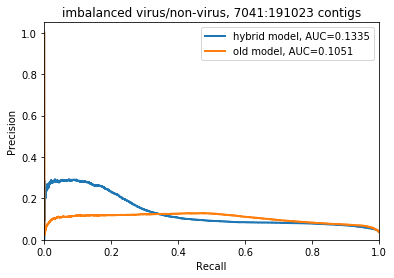

In [65]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_imbalaced_virus_nonvirus_hybrid, precision_imbalaced_virus_nonvirus_hybrid, lw=lw, 
                 label='hybrid model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_hybrid))
        plt.plot(recall_imbalaced_virus_nonvirus_old, precision_imbalaced_virus_nonvirus_old, lw=lw, 
                 label='old model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_old))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('imbalanced virus/non-virus, 7041:191023 contigs')
        plt.legend(loc="upper right")


### Check the performance of the Euk/non-euk model

In [66]:
imbalaced_euk_noneuk = pd.concat([df_euk,df_noneuk])

In [67]:
balaced_euk_noneuk = pd.concat([df_euk,df_noneuk_subsample])

In [68]:
matrix_euk_non_euk_imbalanced = confusion_matrix(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.pred_euk_non_euk)

In [69]:
matrix_euk_non_euk_imbalanced

array([[23114, 17806],
       [78591, 78232]])

In [70]:
matrix_euk_non_euk_balanced = confusion_matrix(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.pred_euk_non_euk)

In [71]:
matrix_euk_non_euk_balanced

array([[23114, 17806],
       [20394, 20526]])

In [72]:
auprc_euk_imbalanced = average_precision_score(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [73]:
auprc_euk_balanced = average_precision_score(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

In [74]:
auprc_euk_balanced

0.49113063826830622

In [75]:
auprc_euk_balanced

0.49113063826830622

In [76]:
precision_euk_imbalanced, recall_euk_imbalanced, thresholds_euk_imbalanced = precision_recall_curve(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [77]:
precision_euk_balanced, recall_euk_balanced, thresholds_euk_balanced = precision_recall_curve(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

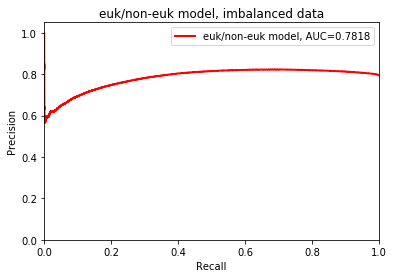

In [78]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_imbalanced, precision_euk_imbalanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_imbalanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, imbalanced data')
        plt.legend(loc="upper right")



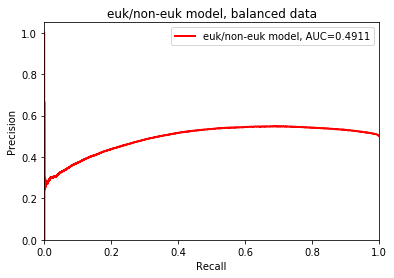

In [79]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_balanced, precision_euk_balanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_balanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, balanced data')
        plt.legend(loc="upper right")



#### Euk/non-Euk itself does not perform very well using the MEGA annotation as ground truth

#### it's still possible, the euk/non-euk works for some family......

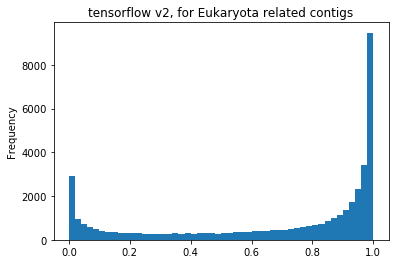

In [138]:
new_table2[new_table2.top_label=='Eukaryota'].Prob_class_1.plot.hist(bins=50, title='tensorflow v2, for Eukaryota related contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


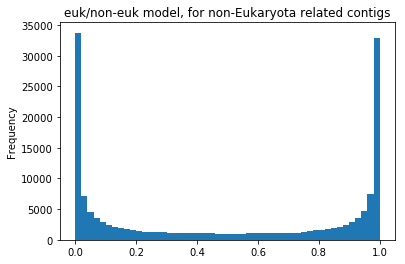

In [81]:
new_table[new_table.top_label!='Eukaryota'][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for non-Eukaryota related contigs')

#### This means removing low euk/non-euk score contigs, will not remove many real virus

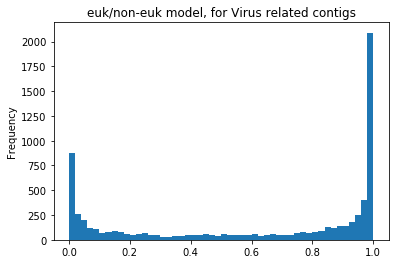

In [82]:
new_table[new_table.label==1].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Virus related contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


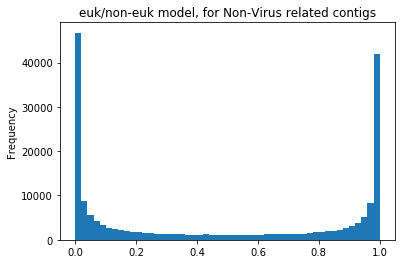

In [83]:
new_table[new_table.label==0][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Non-Virus related contigs')

In [84]:
len(new_table[new_table.probability>=0.9])

34939

In [85]:
len(new_table[new_table.probability>=0.9][new_table.label==1.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


3882

In [86]:
len(new_table[new_table.probability>=0.9][new_table.label==0.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


31057

In [87]:
len(new_table[new_table.probability<=0.1])

111998

In [88]:
len(new_table[new_table.probability<=0.1][new_table.label==1.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


558

In [89]:
len(new_table[new_table.probability<=0.1][new_table.label==0.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


111440

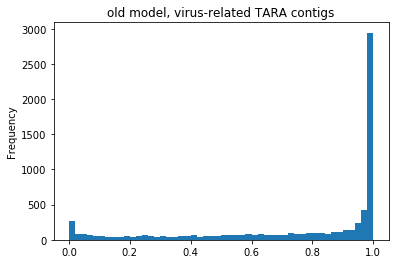

In [90]:
new_table[new_table.label==1.0].probability.plot.hist(bins=50, title = 'old model, virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


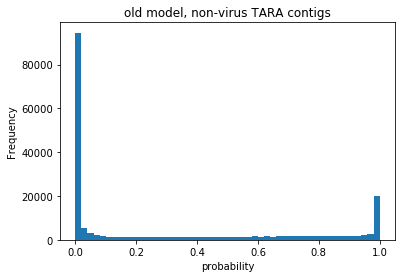

In [91]:
ax = new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].probability.plot.hist(bins=50, title = 'old model, non-virus TARA contigs')
ax.set_xlabel("probability")

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


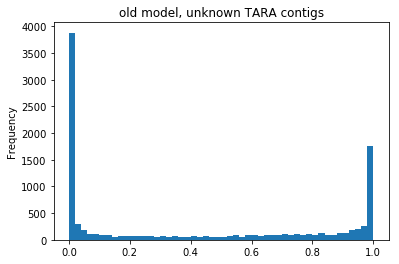

In [92]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].probability.plot.hist(bins=50, title = 'old model, unknown TARA contigs')

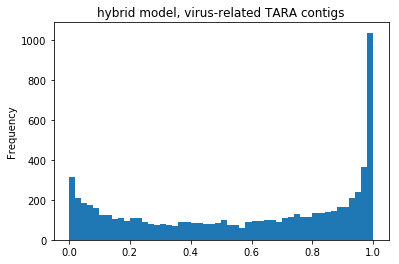

In [93]:
new_table[new_table.label==1.0].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


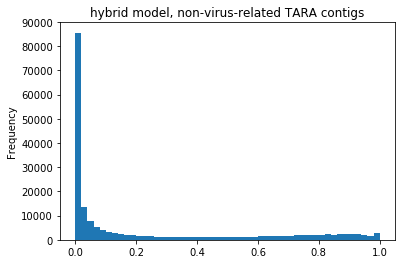

In [94]:
new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, non-virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


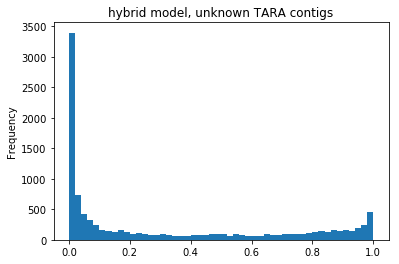

In [95]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, unknown TARA contigs')

### Check the micromous -related contigs

#### most of micromonas contigs has lower euk/non-euk score, prone to be euk....

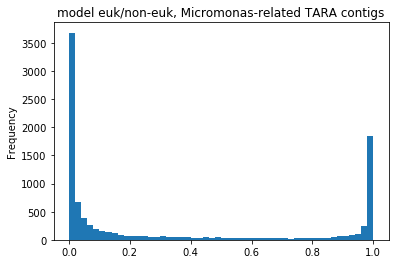

In [174]:
df_micromonus.score_euk_non_euk.plot.hist(bins=50, title = 'model euk/non-euk, Micromonas-related TARA contigs')

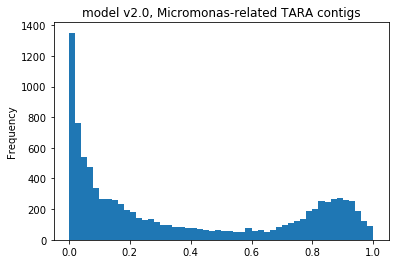

In [172]:
df_micromonus.hybrid_probability.plot.hist(bins=50, title = 'model v2.0, Micromonas-related TARA contigs')

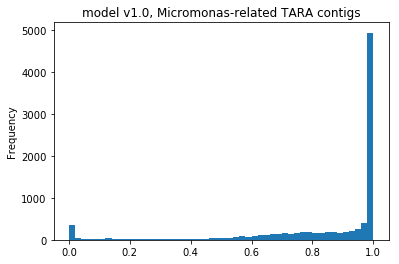

In [173]:
df_micromonus.probability.plot.hist(bins=50, title = 'model v1.0, Micromonas-related TARA contigs')

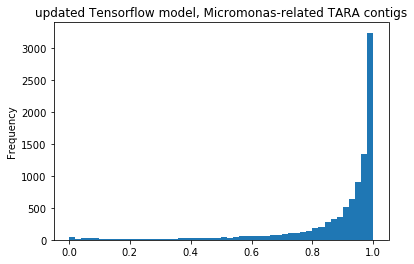

In [139]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

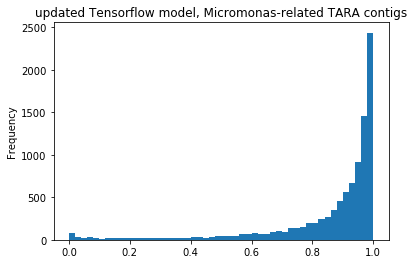

In [59]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

In [ ]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

In [99]:
sub_table = new_table.loc[:,['probability','hybrid_probability','label','tax_id','rank','tax_name']]

In [100]:
sub_table.head()

,probability,hybrid_probability,label,tax_id,rank,tax_name
0,0.000375,0.000097,0.0,1236,class,Gammaproteobacteria
1,0.000088,0.000032,0.0,254161,species,Pseudomonas pachastrellae
2,0.000041,0.000019,0.0,254161,species,Pseudomonas pachastrellae
3,0.000056,0.000021,0.0,286,genus,Pseudomonas
4,0.000040,0.000018,0.0,286,genus,Pseudomonas


In [101]:
grouped = sub_table.groupby(['label'])

In [102]:
import pandas

In [103]:
grouped_category = new_table.groupby('category')

In [104]:
boxplot_data_old = [new_table[new_table.category=='virus'].probability,new_table[new_table.category=='nonvirus'].probability,
               new_table[new_table.category=='unknown'].probability]

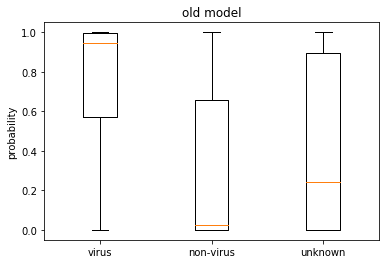

In [105]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_old,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [62]:
boxplot_data_hybrid = [new_table[new_table.category=='virus'].Prob_class_1,new_table2[new_table2.category=='nonvirus'].Prob_class_1,
               new_table2[new_table2.category=='unknown'].Prob_class_1]

AttributeError: 'DataFrame' object has no attribute 'category'

In [73]:
boxplot_data_dl = [new_table2[new_table2.category=='virus'].Prob_class_1.tolist(),new_table2[new_table2.category=='nonvirus'].Prob_class_1.tolist(),
               new_table2[new_table2.category=='unknown'].Prob_class_1.tolist()]

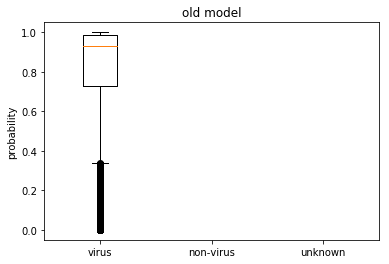

In [76]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_dl,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [74]:
boxplot_data_dl

[[0.043074,
  0.543357,
  0.337569,
  0.8616440000000001,
  0.212259,
  0.41721099999999994,
  0.9449709999999999,
  0.61768,
  0.134796,
  0.37799499999999997,
  0.37799499999999997,
  0.630272,
  0.630272,
  0.535882,
  0.535882,
  0.733777,
  0.733777,
  0.956108,
  0.5857100000000001,
  0.348962,
  0.42447700000000005,
  0.14014200000000002,
  0.0880436,
  0.487029,
  0.07698089999999999,
  0.7620520000000001,
  0.7620520000000001,
  0.956521,
  0.9560620000000001,
  0.998075,
  0.995505,
  0.612191,
  0.7542939999999999,
  0.59291,
  0.9692870000000001,
  0.9898950000000001,
  0.985505,
  0.689181,
  0.57845,
  0.983017,
  0.38594,
  0.8952969999999999,
  0.9917549999999999,
  0.973417,
  0.9732,
  0.9795530000000001,
  0.7421409999999999,
  0.997397,
  0.974649,
  0.559401,
  0.807665,
  0.9776020000000001,
  0.9591149999999999,
  0.588306,
  0.9727520000000001,
  0.959937,
  0.9816540000000001,
  0.9820909999999999,
  0.180067,
  0.96383,
  0.51163,
  0.504995,
  0.0533127,
  0.

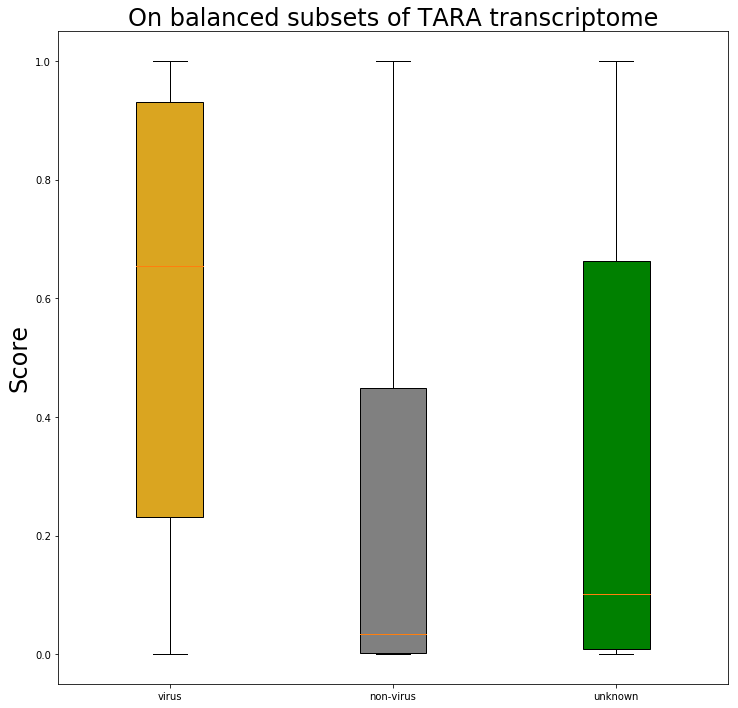

In [139]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_hybrid,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

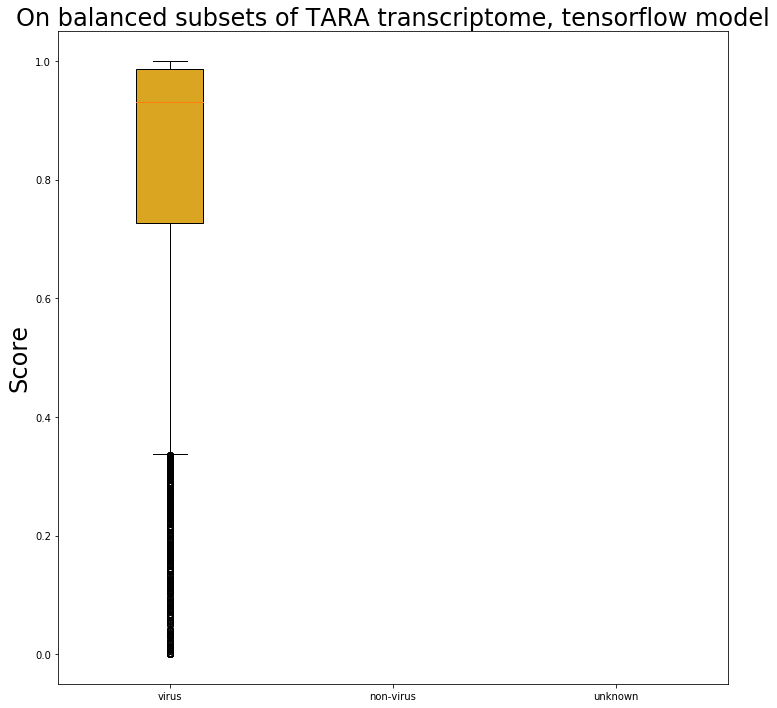

In [75]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_dl,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome, tensorflow model',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [108]:
predict_nonvirus = sub_table.groupby(['label']).get_group(0.0)

In [109]:
predict_nonvirus.head()

,probability,hybrid_probability,label,tax_id,rank,tax_name
0,0.000375,0.000097,0.0,1236,class,Gammaproteobacteria
1,0.000088,0.000032,0.0,254161,species,Pseudomonas pachastrellae
2,0.000041,0.000019,0.0,254161,species,Pseudomonas pachastrellae
3,0.000056,0.000021,0.0,286,genus,Pseudomonas
4,0.000040,0.000018,0.0,286,genus,Pseudomonas


In [110]:
predict_nonvirus[predict_nonvirus.probability>0.99].describe()

,probability,hybrid_probability,label,tax_id
count,19360.000000,19360.000000,19360.0,1.936000e+04
mean,0.998376,0.379285,0.0,3.044789e+05
std,0.002465,0.379769,0.0,4.887216e+05
min,0.990001,0.000009,0.0,-2.000000e+00
25%,0.997727,0.037893,0.0,5.653000e+03
50%,0.999668,0.205307,0.0,5.750600e+04
75%,0.999984,0.778857,0.0,2.965870e+05
max,1.000000,1.000000,0.0,1.904754e+06


In [111]:
grouped = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']].groupby(['rank'])

In [112]:
predict_nonvirus_rank = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']]

In [113]:
def convert_rank(rank):
    if rank == 'no rank':
        return 'no rank'
    else:
        return 'rank'
    

In [114]:
predict_nonvirus_rank['no_rank'] = predict_nonvirus_rank['rank'].map(convert_rank)

In [115]:
predict_nonvirus_rank.head()

,probability,hybrid_probability,rank,no_rank
0,0.000375,0.000097,class,rank
1,0.000088,0.000032,species,rank
2,0.000041,0.000019,species,rank
3,0.000056,0.000021,genus,rank
4,0.000040,0.000018,genus,rank


In [116]:
predict_nonvirus_rank_subset = predict_nonvirus_rank[(predict_nonvirus_rank['rank'] =='class') | (predict_nonvirus_rank['rank'] =='family') | (predict_nonvirus_rank['rank'] =='genus')\
                      | (predict_nonvirus_rank['rank'] =='kingdom')| (predict_nonvirus_rank['rank'] =='no rank')| (predict_nonvirus_rank['rank'] =='order')\
                      | (predict_nonvirus_rank['rank'] =='phylum')| (predict_nonvirus_rank['rank'] =='species')| (predict_nonvirus_rank['rank'] =='superkingdom')]


In [117]:
predict_nonvirus_rank_grouped = predict_nonvirus_rank.groupby(['no_rank'])

In [118]:
predict_nonvirus_rank_grouped.describe()

hybrid_probability                                              \
                     count      mean       std           min       25%   
no_rank                                                                  
no rank            35717.0  0.291535  0.360786  5.826176e-16  0.004860   
rank              165544.0  0.227086  0.320774  1.114855e-20  0.002081   

                                 probability                      \
              50%       75%  max       count      mean       std   
no_rank                                                            
no rank  0.059424  0.653988  1.0     35717.0  0.401543  0.414239   
rank     0.031430  0.420127  1.0    165544.0  0.287961  0.377806   

                                                          
                  min       25%       50%       75%  max  
no_rank                                                   
no rank  6.163252e-27  0.000631  0.232523  0.851715  1.0  
rank     1.608784e-40  0.000074  0.016476  0.611738  1.0

no rank         Axes(0.1,0.15;0.363636x0.75)
rank       Axes(0.536364,0.15;0.363636x0.75)
dtype: object

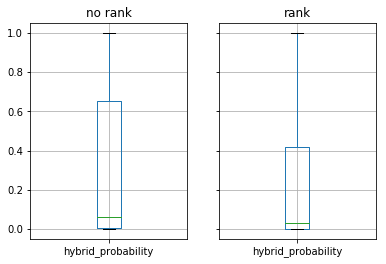

In [119]:
predict_nonvirus_rank_grouped.boxplot(column=['hybrid_probability'])

no rank         Axes(0.1,0.15;0.363636x0.75)
rank       Axes(0.536364,0.15;0.363636x0.75)
dtype: object

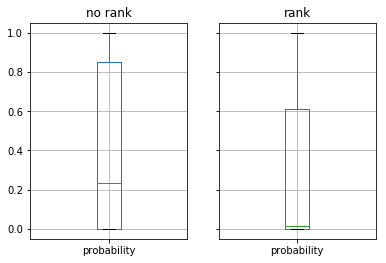

In [120]:
predict_nonvirus_rank_grouped.boxplot(column=['probability'])

In [121]:
9169.0/111440

0.08227745872218234

In [122]:
tax_name_count_99 = predict_nonvirus[predict_nonvirus.probability>0.99].groupby('tax_name').size().reset_index()

In [123]:
tax_name_count_99['percent_99'] = tax_name_count_99[0].apply(lambda x: 100*x/float(tax_name_count_99.sum()))

In [124]:
tax_name_count_99.head()

,tax_name,0,percent_99
0,-2,59,0.304752
1,Acanthamoeba castellanii str. Neff,4,0.020661
2,Acidimicrobiia,1,0.005165
3,Acidithiobacillales bacterium SG8_45,4,0.020661
4,Acinetobacter,8,0.041322


In [125]:
tax_name_count_01 = predict_nonvirus[predict_nonvirus.probability<0.01].groupby('tax_name').size().reset_index()

In [126]:
tax_name_count_01['percent_01'] = tax_name_count_01[0].apply(lambda x: 100*x/float(tax_name_count_01.sum()))

In [127]:
tax_name_count_01.head()


,tax_name,0,percent_01
0,-2,30,0.032458
1,Acanthamoeba castellanii,1,0.001082
2,Acidimicrobiia,1,0.001082
3,Acidobacteria,7,0.007574
4,Acinetobacter,920,0.995380


In [128]:
tax_name = pd.merge(tax_name_count_99,tax_name_count_01,how='inner',on=['tax_name'])

In [129]:
tax_name.head()

,tax_name,0_x,percent_99,0_y,percent_01
0,-2,59,0.304752,30,0.032458
1,Acidimicrobiia,1,0.005165,1,0.001082
2,Acinetobacter,8,0.041322,920,0.995380
3,Actiniaria,6,0.030992,1,0.001082
4,Actinobacteria,42,0.216942,178,0.192584


In [130]:
tax_name['increase'] = tax_name.apply(lambda x:x['percent_99']/x['percent_01'], axis=1)

In [131]:
tax_name.sort_values(by='increase')

,tax_name,0_x,percent_99,0_y,percent_01,increase
324,Rhodobacterales bacterium HTCC2255,2,0.010331,1225,1.325370,0.007794
322,Rhodobacteraceae bacterium SB2,1,0.005165,310,0.335400,0.015400
444,unclassified Methylophilales,1,0.005165,249,0.269402,0.019173
251,Oceanospirillales,2,0.010331,366,0.395988,0.026088
292,Porticoccaceae,1,0.005165,181,0.195830,0.026376
370,Synechococcales,2,0.010331,362,0.391660,0.026376
388,Verrucomicrobia,2,0.010331,345,0.373268,0.027676
323,Rhodobacterales,4,0.020661,659,0.712995,0.028978
81,Candidatus Thioglobus singularis,7,0.036157,1100,1.190128,0.030381
330,SAR116 cluster,1,0.005165,145,0.156881,0.032925


In [132]:
tax_name.sort_values(by='percent_99')

,tax_name,0_x,percent_99,0_y,percent_01,increase
91,Chlorophyceae,1,0.005165,1,0.001082,4.774122
362,Spongiibacter,1,0.005165,53,0.057343,0.090078
120,Cycloclasticus,1,0.005165,23,0.024885,0.207571
221,Microbacteriaceae bacterium BACL25 MAG-120322-...,1,0.005165,12,0.012983,0.397843
115,Cryomorphaceae bacterium BACL22 MAG-120619-bin32,1,0.005165,20,0.021639,0.238706
465,uncultured marine microorganism HF4000_ANIW141I9,1,0.005165,2,0.002164,2.387061
104,Colwellia,1,0.005165,7,0.007574,0.682017
236,Nitrosopumilales,1,0.005165,4,0.004328,1.193530
349,Schizophora,1,0.005165,13,0.014065,0.367240
96,Chromatiales bacterium (ex Bugula neritina AB1),1,0.005165,27,0.029212,0.176819


In [133]:
1587.0/31057

0.05109959107447597

In [134]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('tax_id').size()

tax_id
-2           128
 1          1744
 2          1587
 22           15
 29           16
 85            6
 126          11
 137           1
 146           2
 226         731
 237          12
 286         178
 287           5
 316          13
 356          43
 444           4
 469          17
 506           1
 520           6
 531           5
 543           5
 562          14
 641           9
 657          15
 662          20
 766           6
 838          11
 933           4
 958           8
 963          12
            ... 
 1783270      39
 1783272      52
 1783276       6
 1794811      37
 1797909       9
 1798416       7
 1798559       4
 1802260       7
 1802339       1
 1802371      18
 1805240       9
 1812810       9
 1813033       3
 1817868      27
 1822214       3
 1822215       3
 1822250     124
 1822263       7
 1853229       5
 1853230      13
 1853232       2
 1855377      17
 1856405      16
 1868282       1
 1873462      16
 1890424       8
 1890450       9
 189119

In [135]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('rank').size()

rank
-2                   128
class               1224
family              2846
genus               4805
infraclass            31
infraorder             1
kingdom              330
no rank             7837
order               1775
phylum              1642
species             7654
species group         13
species subgroup       1
subclass              49
subfamily              4
subkingdom             5
suborder              20
subphylum             47
superclass             2
superkingdom        2624
superorder            19
dtype: int64

In [136]:
predict_nonvirus[predict_nonvirus.probability<0.1].groupby('rank').size()

rank
-2                     45
171193                  4
class               16530
family              11575
genus               16066
infraclass              9
infraorder              1
kingdom               280
no rank             16472
order                7921
phylum               9990
species             19646
species group          94
species subgroup        2
subclass               44
subfamily             109
subkingdom              1
suborder                5
subphylum              50
subspecies             10
superclass              1
superfamily             1
superkingdom        12575
superorder              9
dtype: int64

In [137]:
predict_virus = sub_table.groupby(['label']).get_group(1.0)

In [138]:
result = pd.read_csv('/Users/qingpeng/shred.fa.score',sep=' ',header=None,names=['probability','prediction'])

IOError: File /Users/qingpeng/shred.fa.score does not exist

In [ ]:
result

In [ ]:
result.probability.plot.hist(bins=100)